## Checking the compilation with the GPU

In [1]:
import torch

print("CUDA disponible :", torch.cuda.is_available())

print("GPU utilisé :", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "Aucun GPU")

CUDA disponible : False
GPU utilisé : Aucun GPU


## Loading data

In [4]:
import os

# Path to the dataset folder
dataset_path = "./dataset/dataset_blood_group"

# List files in the dataset directory
print("Files in dataset:", os.listdir(dataset_path))



Files in dataset: ['A+', 'A-', 'AB+', 'AB-', 'B+', 'B--', 'O+', 'O-']


## Importing the libraries

In [13]:
from ast import increment_lineno

import tensorflow as tf

from tensorflow import keras

from tensorflow.keras import layers, models

import matplotlib.pyplot as plt

%matplotlib inline

import numpy as np

import pandas as pd

## Splitting the Dataset into train and validation

In [14]:
# Load the data
ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,  # the directory
    labels="inferred",  # using the labels that exist in the folders
    label_mode="categorical",  # one-hot encoding
    batch_size=32,
    image_size=(60, 60),
    shuffle=True,
    seed=42,
    validation_split=0.4,
    subset="training"
)

ds_val = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,  # the directory
    labels="inferred",  # using the labels that exist in the folders
    label_mode="categorical",  # one-hot encoding
    batch_size=32,
    image_size=(60, 60),
    shuffle=True,
    seed=42,
    validation_split=0.4,
    subset="validation"
)

# Print class names before applying any transformations
print("Training class names:", ds_train.class_names)
print("Validation class names:", ds_val.class_names)




Found 6000 files belonging to 8 classes.
Using 3600 files for training.
Found 6000 files belonging to 8 classes.
Using 2400 files for validation.
Training class names: ['A+', 'A-', 'AB+', 'AB-', 'B+', 'B--', 'O+', 'O-']
Validation class names: ['A+', 'A-', 'AB+', 'AB-', 'B+', 'B--', 'O+', 'O-']


## Data Normalization

In [15]:
# Normalize the datasets (apply map function to normalize images)
def normalize(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Normalize pixel values to [0, 1]
    return image, label

# Apply normalization
ds_train = ds_train.map(normalize)
ds_val = ds_val.map(normalize)

# Display the number of batches in each dataset
print('The number of batches in train set:', tf.data.experimental.cardinality(ds_train).numpy())
print('The number of batches in validation set:', tf.data.experimental.cardinality(ds_val).numpy())

The number of batches in train set: 113
The number of batches in validation set: 75


## Another split for data testing

In [16]:
# devide the val data set into val and test data set 
val_batches = tf.data.experimental.cardinality(ds_val)
ds_test = ds_val.take(val_batches // 2)
ds_validation = ds_val.skip(val_batches // 2)

In [18]:
# displaying the shapes :
print('the number of batches in train set :', tf.data.experimental.cardinality(ds_train))
print('the number of batches in validation set :', tf.data.experimental.cardinality(ds_validation))
print('the number of batches in test set :', tf.data.experimental.cardinality(ds_test))

the number of batches in train set : tf.Tensor(113, shape=(), dtype=int64)
the number of batches in validation set : tf.Tensor(38, shape=(), dtype=int64)
the number of batches in test set : tf.Tensor(37, shape=(), dtype=int64)


## ResNet50 Model's functions 

In [19]:
#convolutional_block
def convolutional_block(x, filters, kernel_size=3, stride=2):
    """
    Convolutional block with a skip connection for ResNet architecture.
    Args:
    - x: input tensor
    - filters: number of filters for the convolutional layers
    - kernel_size: size of the convolution filter (default is 3)
    - stride: stride size for the convolution (default is 2)
    """
    # Save the input tensor for the skip connection
    shortcut = x

    # First convolutional layer
    x = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    # Second convolutional layer
    x = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)

    # If the stride is not 1, we apply a 1x1 convolution to the shortcut
    if stride != 1:
        shortcut = layers.Conv2D(filters=filters, kernel_size=1, strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    # Add the skip connection (shortcut)
    x = layers.add([x, shortcut])
    x = layers.ReLU()(x)

    return x


In [20]:
#identity_block
def identity_block(x, filters, kernel_size=3):
    """
    Identity block (the residual block where dimensions are unchanged).
    Args:
    - x: input tensor
    - filters: number of filters for the convolutional layers
    - kernel_size: size of the convolution filter (default is 3)
    """
    shortcut = x

    # First convolutional layer
    x = layers.Conv2D(filters=filters, kernel_size=kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Second convolutional layer
    x = layers.Conv2D(filters=filters, kernel_size=kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Add the skip connection (shortcut)
    x = layers.add([x, shortcut])
    x = layers.ReLU()(x)
    
    return x

In [21]:
#ResNet50
def ResNet50(input_shape=(60, 60, 3), num_classes=8):
    """
    ResNet50-like model built from scratch.
    Args:
    - input_shape: shape of the input images (default is (60, 60, 3))
    - num_classes: number of output classes (default is 8)
    """
    inputs = layers.Input(shape=input_shape)

    # Initial Convolutional Block
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Max Pooling
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Residual Blocks
    # Block 1
    x = convolutional_block(x, 64)
    x = identity_block(x, 64)
    x = identity_block(x, 64)
    x = layers.Dropout(0.5)(x)
    # Block 2
    x = convolutional_block(x, 128)
    x = identity_block(x, 128)
    x = identity_block(x, 128)

    # Block 3
    x = convolutional_block(x, 256)
    x = identity_block(x, 256)
    x = identity_block(x, 256)

    # Block 4
    x = convolutional_block(x, 512)
    x = identity_block(x, 512)
    x = identity_block(x, 512)
    
    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Fully Connected Layer
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    # Output Layer
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Create the model
    model = models.Model(inputs, outputs)

    return model

In [22]:
# Build the ResNet50 model
model_resnet = ResNet50(input_shape=(60, 60, 3), num_classes=8)

# Display the model summary
model_resnet.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 60, 60, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 30, 30,    │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 30, 30,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 30, 30,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 15, 15,    │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 8, 8, 64)  │     36,928 │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 64)  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 8, 8, 64)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 8, 8, 64)  │     36,928 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 8, 8, 64)  │      4,160 │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 64)  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 64)  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 8, 8, 64)  │          0 │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 8, 8, 64)  │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 8, 8, 64)  │     36,928 │ re_lu_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 64)  │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 8, 8, 64)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 8, 8, 64)  │     36,928 │ re_lu_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 64)  │        256 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 18,005,320 (68.68 MB)

 Trainable params: 17,991,752 (68.63 MB)

 Non-trainable params: 13,568 (53.00 KB)

## Model compilation 

In [23]:
opt = tf.keras.optimizers.SGD(learning_rate = 0.0015)
model_resnet.compile(
    

    optimizer=opt,

    loss='categorical_crossentropy',

    metrics=['accuracy']

)


history_resnet = model_resnet.fit(

    ds_train,  # training data generator

    validation_data=ds_validation,  # validation data generator

    epochs=20  # Number of epochs

)

Epoch 1/20


113/113 ━━━━━━━━━━━━━━━━━━━━ 86s 672ms/step - accuracy: 0.1589 - loss: 2.7668 - val_accuracy: 0.1291 - val_loss: 2.0893
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 45s 401ms/step - accuracy: 0.1871 - loss: 2.4164 - val_accuracy: 0.2286 - val_loss: 1.9995
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 51s 450ms/step - accuracy: 0.2834 - loss: 2.0911 - val_accuracy: 0.3520 - val_loss: 1.6618
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.3159 - loss: 1.9016 - val_accuracy: 0.3865 - val_loss: 1.5468
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 206s 2s/step - accuracy: 0.3530 - loss: 1.7705 - val_accuracy: 0.4400 - val_loss: 1.4317
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - accuracy: 0.3965 - loss: 1.6584 - val_accuracy: 0.3215 - val_loss: 1.9302
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 210s 2s/step - accuracy: 0.4047 - loss: 1.5566 - val_accuracy: 0.4416 - val_loss: 1.5424
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - accuracy: 0.4248 - loss: 1.4968 - val_accuracy:

In [24]:
history_resnet = model_resnet.fit(

    ds_train,  # training data generator

    validation_data=ds_validation,  # validation data generator

    epochs=10  # Number of epochs

)

Epoch 1/10


113/113 ━━━━━━━━━━━━━━━━━━━━ 48s 426ms/step - accuracy: 0.7981 - loss: 0.5681 - val_accuracy: 0.7632 - val_loss: 0.6956
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 54s 479ms/step - accuracy: 0.7803 - loss: 0.5739 - val_accuracy: 0.7344 - val_loss: 0.7557
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 57s 505ms/step - accuracy: 0.7996 - loss: 0.5493 - val_accuracy: 0.7862 - val_loss: 0.6291
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 51s 451ms/step - accuracy: 0.7932 - loss: 0.5613 - val_accuracy: 0.7870 - val_loss: 0.6098
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 51s 449ms/step - accuracy: 0.8173 - loss: 0.4863 - val_accuracy: 0.7451 - val_loss: 0.7704
Epoch 6/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 47s 417ms/step - accuracy: 0.8228 - loss: 0.4868 - val_accuracy: 0.7525 - val_loss: 0.7018
Epoch 7/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 47s 415ms/step - accuracy: 0.8234 - loss: 0.4869 - val_accuracy: 0.7664 - val_loss: 0.6769
Epoch 8/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 48s 426ms/step - accuracy: 0.8260 - loss: 0.4655 - val

## Evalutation test of Resnet50

In [25]:
model_resnet.evaluate(ds_test)

37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.6916 - loss: 1.1482


[1.2146363258361816, 0.6824324131011963]

## Training history of ResNet50 

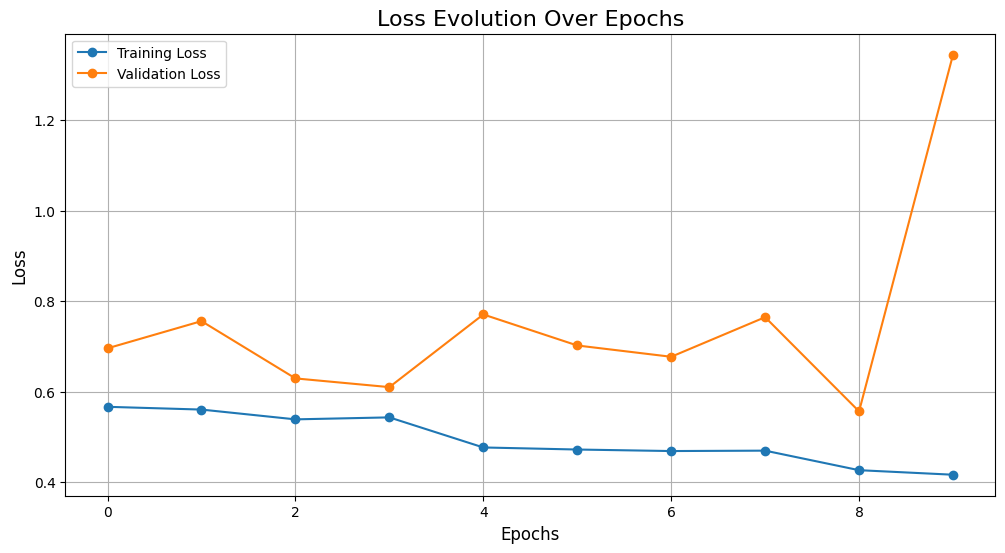

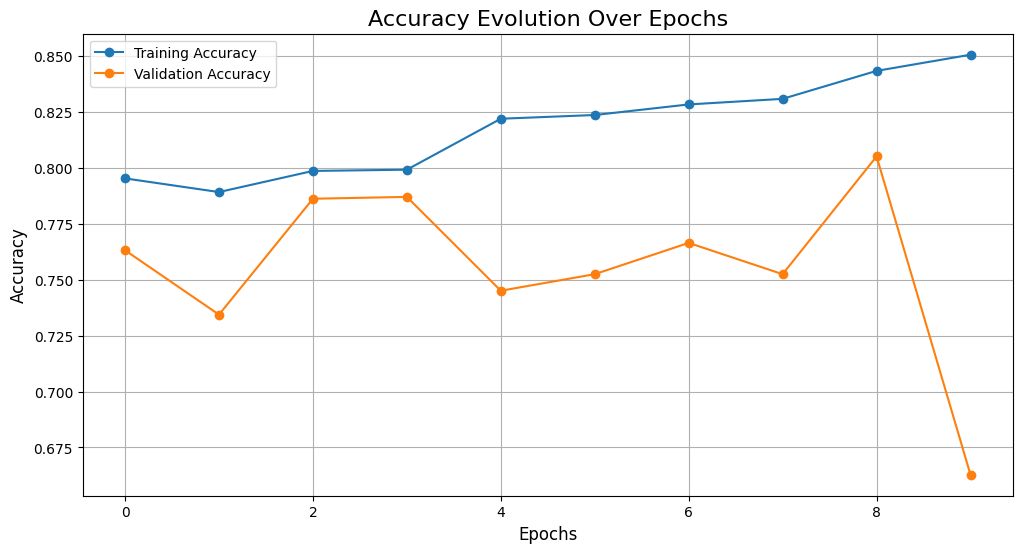

In [26]:
# Assuming `history` contains the training history (from previous training)
history_dict = history_resnet.history

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history_dict['loss'], label='Training Loss', marker='o')
plt.plot(history_dict['val_loss'], label='Validation Loss', marker='o')
plt.title('Loss Evolution Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=10)
plt.grid()
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history_dict['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Accuracy Evolution Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=10)
plt.grid()
plt.show()


## Confusion Matrix 

In [31]:

from sklearn.metrics import confusion_matrix
import seaborn as sns
import os

# Path to the dataset directory (the parent directory containing the class subfolders)
dataset_dir = dataset_path

# Extract class names by listing subdirectories
class_names = os.listdir(dataset_dir)
class_names.sort()  # Sorting to ensure class names are ordered consistently

# Initialize empty lists to store true and predicted labels
true_labels = []
pred_labels = []

# Iterate through the test dataset
for images, labels in ds_test:
    # Get the true labels
    true_labels.append(labels.numpy())

    # Make predictions on the images
    predictions = model_resnet.predict(images)
    pred_labels.append(np.argmax(predictions, axis=1))  # Get class index with highest probability

# Convert the lists to numpy arrays
true_labels = np.concatenate(true_labels, axis=0)
pred_labels = np.concatenate(pred_labels, axis=0)

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(true_labels, axis=1), pred_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


ModuleNotFoundError: No module named 'seaborn'

## ResNet50 Metrics (Precision, Recall and F1-score)

In [21]:

from sklearn.metrics import f1_score, precision_score, recall_score
# Initialize empty lists to store true and predicted labels
true_labels = []
pred_labels = []

# Iterate through the test dataset (ds_test)
for images, labels in ds_test:
    # Get the true labels (one-hot encoded)
    true_labels.append(labels.numpy())

    # Make predictions on the images
    predictions = model_resnet.predict(images)
    pred_labels.append(np.argmax(predictions, axis=1))  # Get class index with highest probability

# Convert the lists to numpy arrays
true_labels = np.concatenate(true_labels, axis=0)
pred_labels = np.concatenate(pred_labels, axis=0)

# Calculate Precision, Recall, and F1 Score with weighted average
precision = precision_score(np.argmax(true_labels, axis=1), pred_labels, average='weighted')
recall = recall_score(np.argmax(true_labels, axis=1), pred_labels, average='weighted')
f1 = f1_score(np.argmax(true_labels, axis=1), pred_labels, average='weighted')

# Print the weighted metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# If you want individual class scores (not averaged)
precision_per_class = precision_score(np.argmax(true_labels, axis=1), pred_labels, average=None)
recall_per_class = recall_score(np.argmax(true_labels, axis=1), pred_labels, average=None)
f1_per_class = f1_score(np.argmax(true_labels, axis=1), pred_labels, average=None)

# Assuming you have class names, you can print individual scores per class
print("\nPrecision per class:")
for i, class_name in enumerate(class_names):
    print(f'{class_name}: {precision_per_class[i]:.4f}')

print("\nRecall per class:")
for i, class_name in enumerate(class_names):
    print(f'{class_name}: {recall_per_class[i]:.4f}')

print("\nF1 Score per class:")
for i, class_name in enumerate(class_names):
    print(f'{class_name}: {f1_per_class[i]:.4f}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━

## Splitting the Dataset and adjusting the appropriate image size for VGG Model inspired  

In [32]:
# Load the data
ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,  # the directory
    labels="inferred",  # using the labels that exist in the folders
    label_mode="categorical",  # one-hot encoding
    batch_size=32,
    image_size=(64, 64),
    shuffle=True,
    seed=42,
    validation_split=0.4,
    subset="training"
)

ds_val = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,  # the directory
    labels="inferred",  # using the labels that exist in the folders
    label_mode="categorical",  # one-hot encoding
    batch_size=32,
    image_size=(64, 64),
    shuffle=True,
    seed=42,
    validation_split=0.4,
    subset="validation"
)

# Print class names before applying any transformations
print("Training class names:", ds_train.class_names)
print("Validation class names:", ds_val.class_names)

Found 6000 files belonging to 8 classes.
Using 3600 files for training.
Found 6000 files belonging to 8 classes.
Using 2400 files for validation.
Training class names: ['A+', 'A-', 'AB+', 'AB-', 'B+', 'B--', 'O+', 'O-']
Validation class names: ['A+', 'A-', 'AB+', 'AB-', 'B+', 'B--', 'O+', 'O-']


## Data Normalization

In [33]:
# Normalize the datasets (apply map function to normalize images)
def normalize(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Normalize pixel values to [0, 1]
    return image, label

# Apply normalization
ds_train = ds_train.map(normalize)
ds_val = ds_val.map(normalize)

# Display the number of batches in each dataset
print('The number of batches in train set:', tf.data.experimental.cardinality(ds_train).numpy())
print('The number of batches in validation set:', tf.data.experimental.cardinality(ds_val).numpy())

The number of batches in train set: 113
The number of batches in validation set: 75


## Test split

In [34]:
# devide the val data set into val and test data set 
val_batches = tf.data.experimental.cardinality(ds_val)
ds_test = ds_val.take(val_batches // 2)
ds_validation = ds_val.skip(val_batches // 2)

In [35]:
# displaying the shapes :
print('the number of batches in train set :', tf.data.experimental.cardinality(ds_train))
print('the number of batches in validation set :', tf.data.experimental.cardinality(ds_validation))
print('the number of batches in test set :', tf.data.experimental.cardinality(ds_test))

the number of batches in train set : tf.Tensor(113, shape=(), dtype=int64)
the number of batches in validation set : tf.Tensor(38, shape=(), dtype=int64)
the number of batches in test set : tf.Tensor(37, shape=(), dtype=int64)


## VGGInspired Model

In [36]:
#VGGinspired
from tensorflow.keras import layers, models

def VGGInspiredModel(input_shape=(64, 64, 3), num_classes=8):
    """
    CNN model inspired by VGG.
    Args:
    - input_shape: shape of the input images (default is (64, 64, 3))
    - num_classes: number of output classes (default is 8)
    Returns:
    - model: A Keras Model instance
    """
    inputs = layers.Input(shape=input_shape)

    # Block 1
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)  

    # Block 2
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)  

    # Block 3
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)  

    # Block 4
    x = layers.Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x) 

    # Fully Connected Layers
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    # Output Layer
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Create the model
    model = models.Model(inputs, outputs)

    return model

# Instantiate the model
model_vgg = VGGInspiredModel(input_shape=(64, 64, 3), num_classes=8)

# Compile the model


# Model Summary
model_vgg.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,013,576 (34.38 MB)

 Trainable params: 9,013,576 (34.38 MB)

 Non-trainable params: 0 (0.00 B)

## Model Compilation

In [37]:
opt = tf.keras.optimizers.Adam(learning_rate = 0.00015)
model_vgg.compile(
    

    optimizer=opt,

    loss='categorical_crossentropy',

    metrics=['accuracy']

)

history = model_vgg.fit(

    ds_train,  # training data generator

    validation_data=ds_validation,  # validation data generator

    epochs=10  # Number of epochs

)

Epoch 1/10


113/113 ━━━━━━━━━━━━━━━━━━━━ 107s 915ms/step - accuracy: 0.1471 - loss: 2.0757 - val_accuracy: 0.1505 - val_loss: 2.0111
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.2852 - loss: 1.8272 - val_accuracy: 0.6283 - val_loss: 0.9949
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 96s 853ms/step - accuracy: 0.5879 - loss: 1.1283 - val_accuracy: 0.7993 - val_loss: 0.5652
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 111s 982ms/step - accuracy: 0.7389 - loss: 0.7128 - val_accuracy: 0.8298 - val_loss: 0.4641
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.7999 - loss: 0.5433 - val_accuracy: 0.8405 - val_loss: 0.4346
Epoch 6/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 102s 900ms/step - accuracy: 0.8195 - loss: 0.4826 - val_accuracy: 0.8438 - val_loss: 0.3832
Epoch 7/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 107s 950ms/step - accuracy: 0.8573 - loss: 0.4114 - val_accuracy: 0.8627 - val_loss: 0.3304
Epoch 8/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accuracy: 0.8673 - loss: 0.3852 - val_a

In [38]:
model_vgg.evaluate(ds_test)

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.8709 - loss: 0.3726


[0.39460277557373047, 0.8623310923576355]

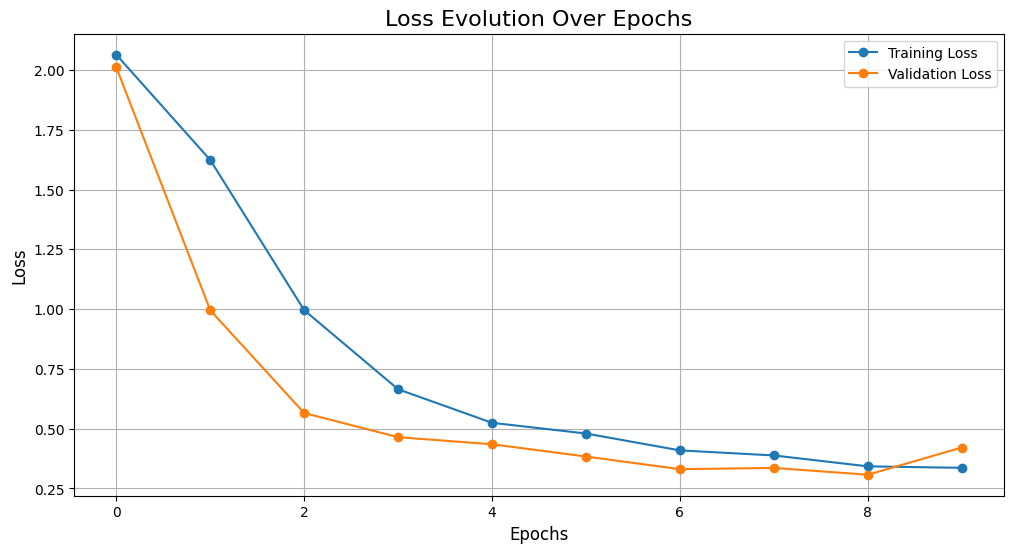

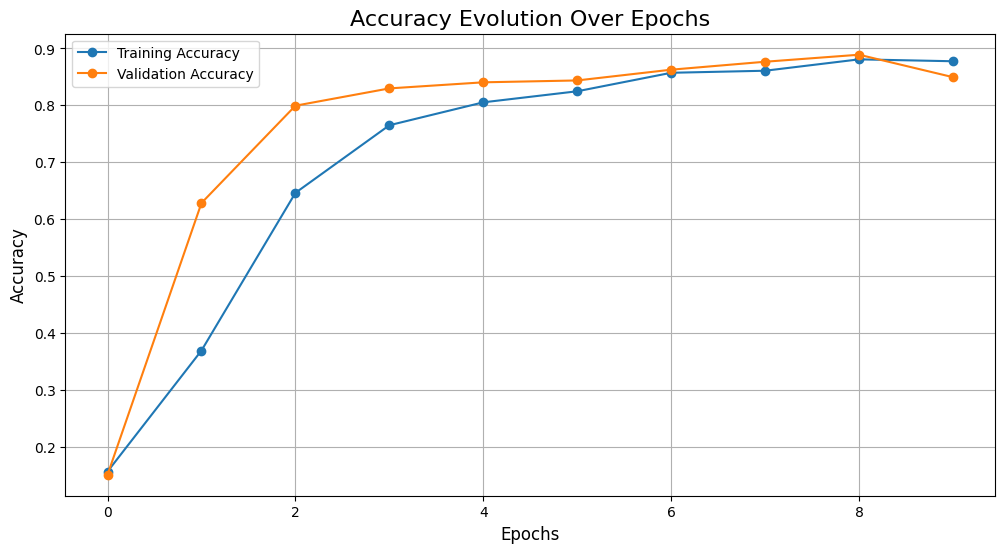

In [39]:
# Assuming `history` contains the training history (from previous training)
history_dict = history.history

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history_dict['loss'], label='Training Loss', marker='o')
plt.plot(history_dict['val_loss'], label='Validation Loss', marker='o')
plt.title('Loss Evolution Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=10)
plt.grid()
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history_dict['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Accuracy Evolution Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=10)
plt.grid()
plt.show()


## Confusion Matrix

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

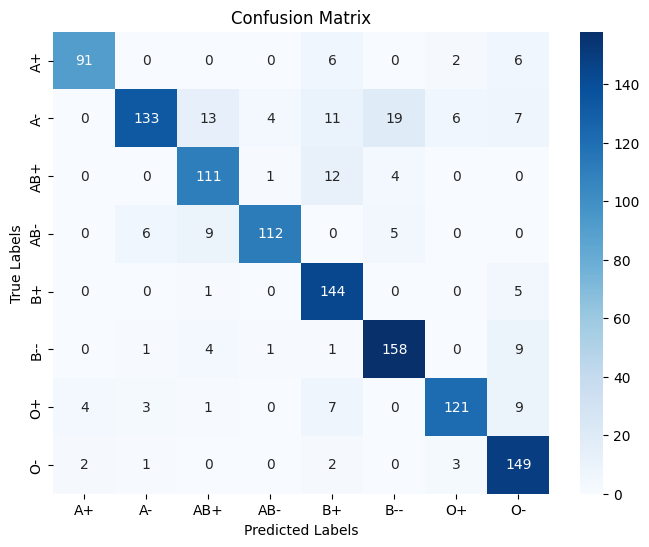

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os

# Path to the dataset directory (the parent directory containing the class subfolders)
dataset_dir = dataset_path

# Extract class names by listing subdirectories
class_names = os.listdir(dataset_dir)
class_names.sort()  # Sorting to ensure class names are ordered consistently

# Initialize empty lists to store true and predicted labels
true_labels = []
pred_labels = []

# Iterate through the test dataset
for images, labels in ds_test:
    # Get the true labels
    true_labels.append(labels.numpy())

    # Make predictions on the images
    predictions = model_vgg.predict(images)
    pred_labels.append(np.argmax(predictions, axis=1))  # Get class index with highest probability

# Convert the lists to numpy arrays
true_labels = np.concatenate(true_labels, axis=0)
pred_labels = np.concatenate(pred_labels, axis=0)

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(true_labels, axis=1), pred_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


## VGG Model Metrics

In [41]:
from sklearn.metrics import f1_score, precision_score, recall_score

# Initialize empty lists to store true and predicted labels
true_labels = []
pred_labels = []

# Iterate through the test dataset (ds_test)
for images, labels in ds_test:
    # Get the true labels (one-hot encoded)
    true_labels.append(labels.numpy())

    # Make predictions on the images
    predictions = model_vgg.predict(images)
    pred_labels.append(np.argmax(predictions, axis=1))  # Get class index with highest probability

# Convert the lists to numpy arrays
true_labels = np.concatenate(true_labels, axis=0)
pred_labels = np.concatenate(pred_labels, axis=0)

# Calculate Precision, Recall, and F1 Score with weighted average
precision = precision_score(np.argmax(true_labels, axis=1), pred_labels, average='weighted')
recall = recall_score(np.argmax(true_labels, axis=1), pred_labels, average='weighted')
f1 = f1_score(np.argmax(true_labels, axis=1), pred_labels, average='weighted')

# Print the weighted metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# If you want individual class scores (not averaged)
precision_per_class = precision_score(np.argmax(true_labels, axis=1), pred_labels, average=None)
recall_per_class = recall_score(np.argmax(true_labels, axis=1), pred_labels, average=None)
f1_per_class = f1_score(np.argmax(true_labels, axis=1), pred_labels, average=None)

# Assuming you have class names, you can print individual scores per class
print("\nPrecision per class:")
for i, class_name in enumerate(class_names):
    print(f'{class_name}: {precision_per_class[i]:.4f}')

print("\nRecall per class:")
for i, class_name in enumerate(class_names):
    print(f'{class_name}: {recall_per_class[i]:.4f}')

print("\nF1 Score per class:")
for i, class_name in enumerate(class_names):
    print(f'{class_name}: {f1_per_class[i]:.4f}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

## Saving the Model

In [42]:
# Save in the HDF5 format

model_vgg.save("fingerprint_model.h5")
print("Model saved as fingerprint_model.h5")

"""
# Save in the SavedModel format
model.save(dataset_path)
print("Model saved in TensorFlow SavedModel format at 'saved_model_fingerprint'")
"""

Model saved as fingerprint_model.h5


'\n# Save in the SavedModel format\nmodel.save(dataset_path)\nprint("Model saved in TensorFlow SavedModel format at \'saved_model_fingerprint\'")\n'

In [43]:
from tensorflow.keras.models import load_model

model = load_model("fingerprint_model.h5")
print("Model loaded from fingerprint_model.h5")


Model loaded from fingerprint_model.h5
